<a href="https://colab.research.google.com/github/inuwamobarak/img-2-img-generation/blob/main/Image_to_image_Generation_Using_depth2img_Pre_trained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image-to-image Generation Using depth2img Pre-trained Models

## Installing Libraries

In [1]:
%pip install --quiet --upgrade diffusers transformers scipy ftfy

In [2]:
%pip install --quiet --upgrade accelerate

## Importing Libraries

In [3]:
import numpy as np
from tqdm import tqdm
from PIL import Image

# PyTorch backend
import torch
from torch import autocast

# Transformers containing tools
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import DPTForDepthEstimation, DPTFeatureExtractor

# Accessing our pipeline
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers.scheduling_pndm import PNDMScheduler

##  Creating Customized Diffusion Pipeline

In [4]:
# Creating a class for customized Diffusion pipeline

class DiffusionPipeline:

    def __init__(self, 
                 vae, 
                 tokenizer, 
                 text_encoder, 
                 unet, 
                 scheduler):
        
        self.vae = vae
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.unet = unet
        self.scheduler = scheduler
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
    def get_text_embeds(self, text):
        # Tokenizing the text
        text_input = self.tokenizer(text, 
                                    padding='max_length', 
                                    max_length=tokenizer.model_max_length, 
                                    truncation=True, 
                                    return_tensors='pt')
        # Embeding the tokenize text
        with torch.no_grad():
            text_embeds = self.text_encoder(text_input.input_ids.to(self.device))[0] # Get embeddings
        return text_embeds


    def get_prompt_embeds(self, prompt):
        if isinstance(prompt, str):
            prompt = [prompt]
        # get conditional prompt embeddings
        cond_embeds = self.get_text_embeds(prompt)
        # get unconditional prompt embeddings
        uncond_embeds = self.get_text_embeds([''] * len(prompt))
        # concatenate the above 2 embeds
        prompt_embeds = torch.cat([uncond_embeds, cond_embeds])
        return prompt_embeds



    def decode_img_latents(self, img_latents):
        img_latents = 1 / self.vae.config.scaling_factor * img_latents
        with torch.no_grad():
            img = self.vae.decode(img_latents).sample
        
        img = (img / 2 + 0.5).clamp(0, 1)
        img = img.cpu().permute(0, 2, 3, 1).float().numpy()
        return img



    def transform_img(self, img):
        # scale images to the range [0, 255] and convert to int
        img = (img * 255).round().astype('uint8')
        # convert to PIL Image objects
        img = [Image.fromarray(i) for i in img]
        return img


    def encode_img_latents(self, img, latent_timestep):
        if not isinstance(img, list):
            img = [img]
        
        img = np.stack([np.array(i) for i in img], axis=0)
        # scale images to the range [-1, 1]
        img = 2 * ((img / 255.0) - 0.5)
        img = torch.from_numpy(img).float().permute(0, 3, 1, 2)
        img = img.to(self.device)

        # encode images
        img_latents_dist = self.vae.encode(img)
        img_latents = img_latents_dist.latent_dist.sample()
        
        # scale images
        img_latents = self.vae.config.scaling_factor * img_latents
        
        # add noise to the latents
        noise = torch.randn(img_latents.shape).to(self.device)
        img_latents = self.scheduler.add_noise(img_latents, noise, latent_timestep)

        return img_latents


## Creating The ImgPipeline

In [5]:
class Depth2ImgPipeline(DiffusionPipeline):
    def __init__(self, 
                 vae, 
                 tokenizer, 
                 text_encoder, 
                 unet, 
                 scheduler, 
                 depth_feature_extractor, 
                 depth_estimator):
        
        super().__init__(vae, tokenizer, text_encoder, unet, scheduler)

        self.depth_feature_extractor = depth_feature_extractor
        self.depth_estimator = depth_estimator


    def get_depth_mask(self, img):
        if not isinstance(img, list):
            img = [img]

        width, height = img[0].size
        
        # pre-process the input image and get its pixel values
        pixel_values = self.depth_feature_extractor(img, return_tensors="pt").pixel_values

        # use autocast for automatic mixed precision (AMP) inference
        with autocast('cuda'):
            depth_mask = self.depth_estimator(pixel_values).predicted_depth
        
        # get the depth mask
        depth_mask = torch.nn.functional.interpolate(depth_mask.unsqueeze(1),
                                                     size=(height//8, width//8),
                                                     mode='bicubic',
                                                     align_corners=False)
        
        # scale the mask to range [-1, 1]
        depth_min = torch.amin(depth_mask, dim=[1, 2, 3], keepdim=True)
        depth_max = torch.amax(depth_mask, dim=[1, 2, 3], keepdim=True)
        depth_mask = 2.0 * (depth_mask - depth_min) / (depth_max - depth_min) - 1.0
        depth_mask = depth_mask.to(self.device)

        # replicate the mask for classifier free guidance 
        depth_mask = torch.cat([depth_mask] * 2)
        return depth_mask



    
    def denoise_latents(self, 
                        img,
                        prompt_embeds,
                        depth_mask,
                        strength,
                        num_inference_steps=20,
                        guidance_scale=7.5,
                        height=512, width=512):
        
        # clip the value of strength to ensure strength lies in [0, 1]
        strength = max(min(strength, 1), 0)

        # compute timesteps
        self.scheduler.set_timesteps(num_inference_steps)

        init_timestep = int(num_inference_steps * strength)
        t_start = num_inference_steps - init_timestep
        
        timesteps = self.scheduler.timesteps[t_start: ]
        num_inference_steps = num_inference_steps - t_start

        latent_timestep = timesteps[:1].repeat(1)

        latents = self.encode_img_latents(img, latent_timestep)

        # use autocast for automatic mixed precision (AMP) inference
        with autocast('cuda'):
            for i, t in tqdm(enumerate(timesteps)):
                latent_model_input = torch.cat([latents] * 2)
                latent_model_input = torch.cat([latent_model_input, depth_mask], dim=1)
                
                # predict noise residuals
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)['sample']

                # separate predictions for unconditional and conditional outputs
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                
                # perform guidance
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # remove the noise from the current sample i.e. go from x_t to x_{t-1}
                latents = self.scheduler.step(noise_pred, t, latents)['prev_sample']

        return latents


    def __call__(self, 
                 prompt, 
                 img, 
                 strength=0.8,
                 num_inference_steps=50,
                 guidance_scale=7.5,
                 height=512, width=512):


        prompt_embeds = self.get_prompt_embeds(prompt)

        depth_mask = self.get_depth_mask(img)

        latents = self.denoise_latents(img,
                                       prompt_embeds,
                                       depth_mask,
                                       strength,
                                       num_inference_steps,
                                       guidance_scale,
                                       height, width)

        img = self.decode_img_latents(latents)

        img = self.transform_img(img)
        
        return img


In [6]:
# Setting a GPU device
device = 'cuda'

##  Loading Functions for Preprocessing Text

In [7]:
# Loading autoencoder for reconstructing the image
vae = AutoencoderKL.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='vae').to(device)

# Load tokenizer and the text encoder
tokenizer = CLIPTokenizer.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='text_encoder').to(device)

# Load UNet model
unet = UNet2DConditionModel.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='unet').to(device)

# Load scheduler to adjusts the learning rate
scheduler = PNDMScheduler(beta_start=0.00085, 
                          beta_end=0.012, 
                          beta_schedule='scaled_linear', 
                          num_train_timesteps=1000)


## Utilizing Dense Prediction Transformers (DPT)

In [8]:
# Load DPT Depth Estimator for measuring the distance of each pixel
depth_estimator = DPTForDepthEstimation.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='depth_estimator')

# Load DPT Feature Extractor for dense prediction
depth_feature_extractor = DPTFeatureExtractor.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='feature_extractor')


/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


## Creating Variable Instance of Pipeline

In [9]:
depth2img = Depth2ImgPipeline(vae, 
                              tokenizer, 
                              text_encoder, 
                              unet, 
                              scheduler,
                              depth_feature_extractor,
                              depth_estimator)

## Loading Image

In [10]:
import urllib.parse as parse
import os
import requests

# Determine whether a string is a URL or not
def check_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

In [ ]:
# Load an image
def load_image(image_path):
    if check_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

<a href="https://www.freepik.com/free-vector/two-red-roses-white_5982422.htm#query=two%20roses&position=0&from_view=keyword&track=ais">Image by brgfx</a> on Freepik

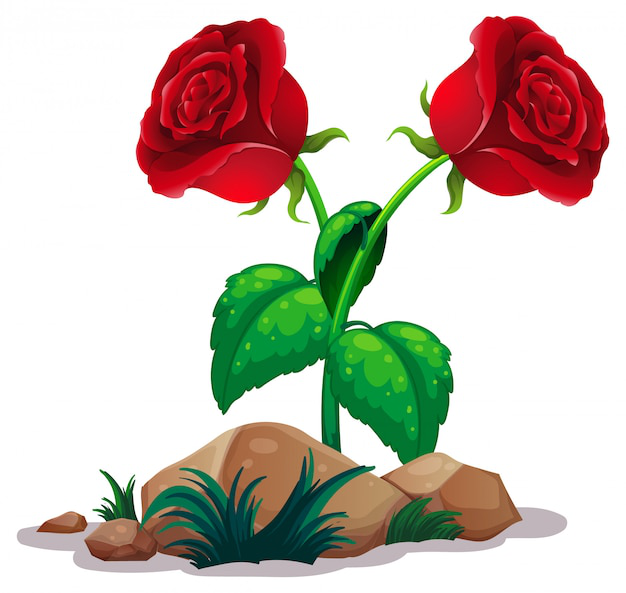

In [11]:
url = "https://img.freepik.com/free-vector/two-red-roses-white_1308-35268.jpg?size=626&ext=jpg&uid=R21895281&ga=GA1.1.821631087.1678296847&semt=ais"
img = load_image(url)
img

## Generating new Images

In [12]:
#depth2img("two hibiscus flowers", img)[0]

<a href="https://www.freepik.com/free-vector/cute-pink-bicycle-isolated_10604104.htm#from_view=detail_alsolike">Image by macrovector</a> on Freepik

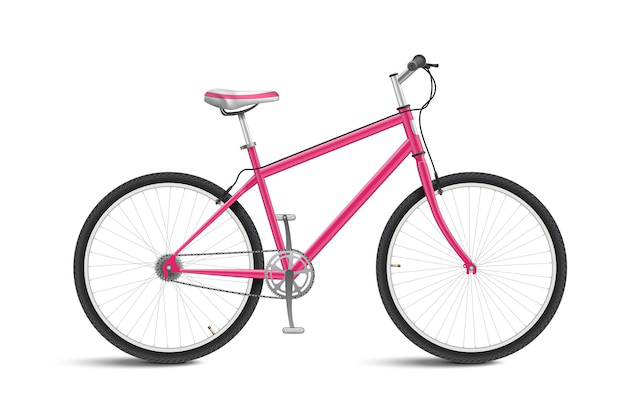

In [13]:
url = "https://img.freepik.com/free-vector/cute-pink-bicycle-isolated_1284-43044.jpg?t=st=1684396069~exp=1684396669~hmac=fb265438f0680c00b7c156182201f5c15b602bd1733a5b051a2d9c77ff83a4fd"
img = load_image(url)
img

49it [00:07,  6.27it/s]


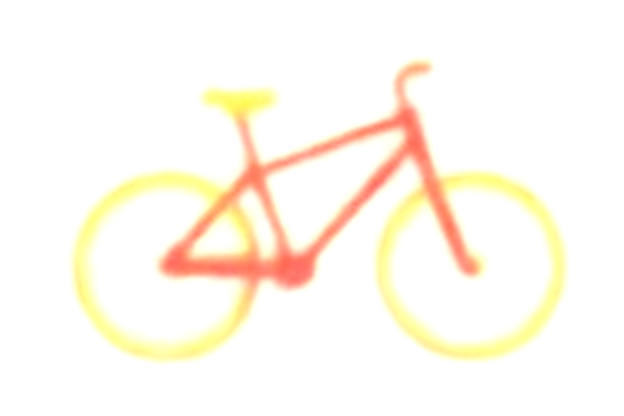

In [14]:
depth2img("motorcycle", img)[0]